디렉터님께..

질문이 있습니다.
데이터 전처리 과정에서 결측치가 발생하였지만 과제 내에서 별도로 제거하지 않았습니다. 결측치가 상당히 많은 파일도 있어서 진행하진 않았는데,
디렉터님께서 어떤 의도를 가지고 데이터를 주셨는지 궁금합니다. 예를 들어 이 파일에서는 결측치 제거를 진행해야되었다는 등 알려주시면 감사하겠습니다.

그리고 강의중에 초보자인 경우 Power BI와 tableau 중 어떤 것을 먼저 집중적으로 학습하면 좋은지 질문드렸었는데,
우선 Power BI 강의를 먼저 듣고 조금은 익히게 되어 과제 내 추가 분석으로 제시하였습니다.. 추후 tableau 강의도 듣고 학습해볼 계획입니다!

9주차까지 긴 시간동안 유익하고 열정적으로 강의 및 피드백 주셔서 감사합니다!

# **Introduction**

## **0.Data Extract - SQL**

### **1) 5개의 테이블(order, customer, course, refund, user)을 하나의 테이블로 조인하는 쿼리**

In [ ]:
select *
from "order" orders
left join customer on orders.id = id
left join refund refunds on orders.id = refunds.id
left join user users on orders.id = users.id
left join course courses on orders.id = courses.id;

### **2)(Order) 각 강의별 가장 첫 번째로 신청한 유저와 가장 마지막에 신청한 유저와 그 때의 날짜 제시(First_Value, Last_value, partition by)**

In [ ]:
with summary as (
  select
      name as "order",
      min(id) as 첫_신청자,
      min(created_at) as 첫_신청_날짜,
      max(id) as 마지막_신청자,
      max(created_at) as 마지막_신청_날짜
  from
     "order"
group by
    name
)
select * from summary;

### **3) Order 테이블 list_price 월별 합계 후 전달 대비 증가량 및 증가 비율 제시 (lead, lag)**

In [ ]:
with salesprice as (
    select
        date_trunc('month', created_at::timestamp) as month,
        sum(list_price) as salesprice
    from
        "order"
    group by
        date_trunc('month', created_at::timestamp)
)
select
    to_char(month, 'yyyy-mm') as month,
    salesprice,
    salesprice - lag(salesprice) over (order by month) as increase_amount,
    round(((salesprice - lag(salesprice) over (order by month)) / nullif(lag(salesprice) over (order by month), 0)) * 100, 2) as increase_percentage
from
    salesprice;

## **1. 목표(가설) 설정**

- 분석범위:
    - 2015년부터 2024년까지 각각의 5개 데이터 파일(order, customer, course, refund, user)
- 분석목표:
    - 각 데이터별 특징 분석
    - 2022년도 월별 각 데이터 추세 분석
- 분석도구: SQL, Python, Power BI
- 기대효과:
    - 고객들의 강의 신청 유형 분석을 통한 고객별 강의할인 쿠폰, 이벤트 기획 등 가능
    - 환불 고객이 많은 강의와 인기있는 강의 분석을 통한 고객유지 방안수립
    - 회원 가입 후 마지막 로그인 분석을 통해 휴면 계정회원 이탈 방지 대책 수립가능  

## **2. 데이터 선정 및 분석**

### **1) 데이터 수집**

- 강의 주문, 수강, 환불, 고객정보와 관련된 데이터들 수집
   - order.csv, course.csv, refund.csv, customer.csv, user.csv 데이터 이용

### **2) EDA (탐색적 데이터 분석) 및 데이터 정제 실시**

In [ ]:
!pip install pandas

In [ ]:
# 데이터 분석에 필요한 pandas, numpy, matploylib, seaborn 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [ ]:
# 5개 데이터 불러오기
order = pd.read_csv('order-9968.txt')
course = pd.read_csv('course-9968.csv')
customer = pd.read_csv('customer-9968.csv')
refund = pd.read_csv('refund-9968.csv')
user = pd.read_csv('user-9968.csv')

In [ ]:
order.head()

,id,type,state,name,created_at,updated_at,customer_id,list_price,sale_price,discount_price,tax_free_price
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,2022-12-31 23:42:52,1083679,10000,0,10000,0
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,2022-12-31 23:39:25,129176,40000,40000,0,40000
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,2022-12-31 23:39:17,1072552,20000,10000,10000,10000
3,1600577,ORDER,COMPLETED,백엔드 개발자를 위,2022-12-31 23:35:52,2022-12-31 23:36:09,1083664,20000,20000,10000,20000
4,1600574,ORDER,COMPLETED,React Nati,2022-12-31 23:30:51,2022-12-31 23:31:13,1033553,20000,20000,0,20000


In [ ]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284035 entries, 0 to 284034
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              284035 non-null  int64 
 1   type            284035 non-null  object
 2   state           284035 non-null  object
 3   name            284035 non-null  object
 4   created_at      284035 non-null  object
 5   updated_at      284035 non-null  object
 6   customer_id     284035 non-null  int64 
 7   list_price      284035 non-null  int64 
 8   sale_price      284035 non-null  int64 
 9   discount_price  284035 non-null  int64 
 10  tax_free_price  284035 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 23.8+ MB


In [ ]:
# 각 컬럼별 결측치 수 확인
order.isnull().sum()

id                0
type              0
state             0
name              0
created_at        0
updated_at        0
customer_id       0
list_price        0
sale_price        0
discount_price    0
tax_free_price    0
dtype: int64

In [ ]:
course.head()

,id,type,state,created_at,updated_at,title,description,close_at,total_class_hours,keywords
0,214903,COURSE,ONGOING,2022-12-27 1:33,2022-12-27 1:33,(B2G) K-Di-214903,NaN,NaN,NaN,NaN
1,214898,COURSE,ONGOING,2022-12-26 12:25,2022-12-26 12:25,(B2G) K-Di-214898,NaN,NaN,NaN,NaN
2,214897,COURSE,ONGOING,2022-12-26 12:20,2022-12-26 12:20,(B2G) K-Di-214897,NaN,NaN,NaN,NaN
3,214896,COURSE,ONGOING,2022-12-26 12:17,2022-12-26 12:17,(B2G) K-Di-214896,NaN,NaN,NaN,NaN
4,214895,COURSE,ONGOING,2022-12-26 12:14,2022-12-26 12:14,(B2G) K-Di-214895,NaN,NaN,NaN,NaN


In [ ]:
course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 722 non-null    int64  
 1   type               722 non-null    object 
 2   state              722 non-null    object 
 3   created_at         722 non-null    object 
 4   updated_at         722 non-null    object 
 5   title              722 non-null    object 
 6   description        554 non-null    object 
 7   close_at           15 non-null     object 
 8   total_class_hours  578 non-null    float64
 9   keywords           540 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 56.5+ KB


In [ ]:
# 각 컬럼별 결측치 수 확인
course.isnull().sum()

id                     0
type                   0
state                  0
created_at             0
updated_at             0
title                  0
description          168
close_at             707
total_class_hours    144
keywords             182
dtype: int64

In [ ]:
customer.head()

,id,type,state,created_at,updated_at,user_id,name,phone,email
0,1482394,USER,NORMAL,2024/01/24 4:44,2024/01/24 13:54,959919,USER_1482394,1012345678,USER_1482394@notexistemail.com
1,1482300,USER,NORMAL,2024/01/24 4:43,2024/01/25 6:10,818301,USER_1482300,1012345678,USER_1482300@notexistemail.com
2,1482071,USER,NORMAL,2024/01/24 4:41,2024/01/25 7:46,543671,USER_1482071,1012345678,USER_1482071@notexistemail.com
3,1445268,USER,NORMAL,2023/12/27 4:17,2023/12/27 4:17,824733,USER_1445268,1012345678,USER_1445268@notexistemail.com
4,1445150,USER,NORMAL,2023/12/27 4:15,2023/12/27 4:15,767404,USER_1445150,1012345678,USER_1445150@notexistemail.com


In [ ]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123013 entries, 0 to 123012
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          123013 non-null  int64 
 1   type        123013 non-null  object
 2   state       123013 non-null  object
 3   created_at  123013 non-null  object
 4   updated_at  123013 non-null  object
 5   user_id     123013 non-null  int64 
 6   name        123013 non-null  object
 7   phone       123013 non-null  int64 
 8   email       123013 non-null  object
dtypes: int64(3), object(6)
memory usage: 8.4+ MB


In [ ]:
# 각 컬럼별 결측치 수 확인
customer.isnull().sum()

id            0
type          0
state         0
created_at    0
updated_at    0
user_id       0
name          0
phone         0
email         0
dtype: int64

In [ ]:
user.head()

,id,type,state,created_at,updated_at,last_login_at,username
0,1075089,USER,NORMAL,2022-12-31 23:39:19,2023-12-02 00:00:22,2022-12-31 23:44:35,dkfk
1,1075079,USER,NORMAL,2022-12-31 23:08:47,2023-12-03 23:34:39,2023-12-03 23:34:40,toqu
2,1075074,USER,NORMAL,2022-12-31 22:46:31,2023-10-19 11:49:10,2023-10-19 11:49:10,theh
3,1075064,USER,NORMAL,2022-12-31 22:03:14,2023-10-06 18:20:51,2023-10-06 18:20:51,tige
4,1075059,USER,NORMAL,2022-12-31 21:35:42,2023-02-17 01:54:52,2023-02-17 01:54:52,kyg6


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122989 entries, 0 to 122988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             122989 non-null  int64 
 1   type           122989 non-null  object
 2   state          122989 non-null  object
 3   created_at     122989 non-null  object
 4   updated_at     122989 non-null  object
 5   last_login_at  122989 non-null  object
 6   username       122988 non-null  object
dtypes: int64(1), object(6)
memory usage: 6.6+ MB


In [ ]:
# 각 컬럼별 결측치 수 확인
user.isnull().sum()

id               0
type             0
state            0
created_at       0
updated_at       0
last_login_at    0
username         1
dtype: int64

In [ ]:
refund.head()

,id,type,state,created_at,updated_at,user_id,course_id,amount,tax_free_amount
0,72124,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 7:29,2022-12-30 7:29,619833.0,214323.0,-20000,-20000
1,72121,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 7:01,2022-12-30 7:01,146614.0,213905.0,-10000,-10000
2,72119,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 6:08,2022-12-30 6:08,541404.0,214402.0,0,0
3,72117,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 6:00,2022-12-30 6:00,1056095.0,203935.0,-10000,-10000
4,72116,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 5:57,2022-12-30 5:57,98880.0,213244.0,-20000,-20000


In [ ]:
refund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12674 entries, 0 to 12673
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               12674 non-null  int64  
 1   type             12674 non-null  object 
 2   state            12674 non-null  object 
 3   created_at       12674 non-null  object 
 4   updated_at       12674 non-null  object 
 5   user_id          12659 non-null  float64
 6   course_id        12075 non-null  float64
 7   amount           12674 non-null  int64  
 8   tax_free_amount  12674 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 891.3+ KB


In [ ]:
# 각 컬럼별 결측치 수 확인
refund.isnull().sum()

id                   0
type                 0
state                0
created_at           0
updated_at           0
user_id             15
course_id          599
amount               0
tax_free_amount      0
dtype: int64

## **Descriptive Analysis**

### **3) 데이터 분석**

#### **(Order) 2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일 분석 (status = COMPLETED 기준)**

- 가장 매출이 높았던 3일은 1월 3일, 7일, 5일, 순이었으며, 가장 낮았던 3일은 1월 1일, 22일, 29일 순이었음.

In [ ]:
# to_datetime 함수를 이용하여 create_at를 날짜형 데이터로 변환
order['created_at'] = pd.to_datetime(order['created_at'])

In [ ]:
# 2022년 1월 데이터 필터링
jan_2022_data = order[(order['created_at'].dt.year == 2022) & (order['created_at'].dt.month == 1)]

# state가 'COMPLETED'인 데이터만 필터링
jan_2022_completed = jan_2022_data[jan_2022_data['state'] == 'COMPLETED']

# 날짜별 매출 합계 구하기
daily_sales = jan_2022_completed.groupby(jan_2022_completed['created_at'].dt.date)['list_price'].sum().reset_index()

# 상위 3일과 하위 3일 추출하여 병합
top_and_bottom_days = pd.concat([daily_sales.nlargest(3, 'list_price'), daily_sales.nsmallest(3, 'list_price')])

# list_price 열에 천 단위 구분 추가
top_and_bottom_days['list_price'] = top_and_bottom_days['list_price'].apply(lambda x: '{:,.0f}'.format(x))

# 결과
top_and_bottom_days[['created_at', 'list_price']]

,created_at,list_price
2,2022-01-03,"48,980,000"
6,2022-01-07,"34,700,000"
4,2022-01-05,"33,840,000"
0,2022-01-01,"6,260,000"
21,2022-01-22,"6,850,000"
28,2022-01-29,"8,920,000"


#### **(Order) 2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일의 매출액(list_price)과, 주문 수, 신청자 수, 강의 수**

- 가장 매출이 높았던 3일
    - 2022-01-03 48,980,000원, 2022-01-07 34,700,000원, 2022-01-05 33,840,000원
    - 주문 수: 3,876개, 신청자 수: 4,444명, 강의 수: 197개
- 가장 매출이 낮았던 3일
    - 2022-01-01 6,260,000원,  2022-01-22 ,685,000원,   2022-01-29 , 89,200원
    - 주문 수: 703개, 신청 수:787명 강의수:174개

In [ ]:
# 상위 3일과 하위 3일의 주문 수, 신청자 수, 강의 수 계산
top_3_order_count = top_3_data['customer_id'].nunique()
top_3_user_count = top_3_data['id'].nunique()
top_3_course_count = top_3_data['name'].nunique()

bottom_3_order_count = bottom_3_data['customer_id'].nunique()
bottom_3_user_count = bottom_3_data['id'].nunique()
bottom_3_course_count = bottom_3_data['name'].nunique()

print("가장 매출이 높은 3일:")
print("\n주문 수:", top_3_order_count)
print("신청자 수:", top_3_user_count)
print("강의 수:", top_3_course_count)

print("\n가장 매출이 낮은 3일:")
print("\n주문 수:", bottom_3_order_count)
print("신청자 수:", bottom_3_user_count)
print("강의 수:", bottom_3_course_count)

가장 매출이 높은 3일:

주문 수: 3876
신청자 수: 4444
강의 수: 197

가장 매출이 낮은 3일:

주문 수: 703
신청자 수: 787
강의 수: 174


#### **(Order) 월별 각 강의 별 할인율 분석**

- 각 월별 각 강의별 할인율을 계산하였으며, 그 중 가장 높은 할인율을 가진 강의는 '[내부용]Apach' 으로 할인율은 200000.0.

In [ ]:
# 각 월별 강의 별 할인율 계산
monthly_discount_rates = order.groupby([order['created_at'].dt.year, order['created_at'].dt.month, 'name'])['discount_price'].mean()

# 할인율을 %로 변환하고 소수점 첫 번째 자리까지 표시하는 함수 정의
def format_discount_rate(rate):
    return '{:,.1f}%'.format(rate * 100)

# 결과 출력
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(monthly_discount_rates.apply(format_discount_rate))

created_at  created_at  name       
2022        1           (B2B) 42SE              0.0%
                        (B2B) K-Di      1,500,000.0%
                        (B2B) 디캠프               0.0%
                        (B2B) 비바리퍼              0.0%
                        (B2B) 빌리지베              0.0%
                        (B2B) 와이즈셀              0.0%
                        (B2B) 이지엠앤              0.0%
                        (B2B) 주식회사              0.0%
                        (B2B) 크몽 온              0.0%
                        (B2B) 하나금융              0.0%
                        100개의 클론디자        925,581.4%
                        100억을 움직이는        439,613.5%
                        13만 구독자 피피        896,551.7%
                        150만 원으로 월      1,095,890.4%
                        15명의 전문 애널      1,410,256.4%
                        2030을 위한 내        380,000.0%
                        30개 글감으로 에        485,148.5%
                        30개 프로젝트로         796,954.3%
          

In [ ]:
# 가장 높은 할인율을 가진 강의 찾기
max_discount_course = monthly_discount_rates.idxmax()
max_discount_rate = monthly_discount_rates.max()

# 결과
print(f"가장 높은 할인율을 가진 강의는 '{max_discount_course[2]}'으로 할인율은 {format_discount_rate(max_discount_rate)}.")

가장 높은 할인율을 가진 강의는 '[내부용]Apach'으로 할인율은 20,000,000.0%.


#### **(Course) 강의 키워드에서 가장 많이 언급된 단어 분석**

- 강의 키워드 열에서 많이 언급된 단어를 찾기 위해서는 'keywords' 열을 토큰화하여서 가장 많이 언급되고 있는 단어를 찾아야 함
- 'keywords' 열에서 가장 많이 언급된 단어가 ','로 나타났지만, 글자가 아니기 때문에, 두번째로 많이 언급되는 단어를 구하는 코드를 사용하였으며, '평생소장'이 86회로 가장 많이 언급된 단어로 볼 수 있음

In [ ]:
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/yunjh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/yunjh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# 'keywords' 열에서 텍스트 추출
keywords_text = ' '.join(course['keywords'].dropna())

# 텍스트 토큰화
tokens = word_tokenize(keywords_text)

# 소문자로 변환
tokens = [word.lower() for word in tokens]
tokens = [word for word in tokens if word not in stop_words]

# 단어 빈도 계산
word_counts = Counter(tokens)

# 가장 많이 언급된 단어 찾기
most_common_word = word_counts.most_common(1)[0]

print("가장 많이 언급된 단어:", most_common_word)

가장 많이 언급된 단어: (',', 6317)


In [ ]:
# 두 번째로 많이 언급된 단어 찾기
most_common_word2 = word_counts.most_common(2)[1]
print("두 번째로 많이 언급된 단어:", most_common_word2)

두 번째로 많이 언급된 단어: ('평생소장', 86)


#### **(Refund) 환불이 가장 많은 강의 분석**

- 환불이 많았던 강의 ID는 213368이며, 269회 환불되었었음.

In [ ]:
# 각 강의별 환불 횟수 계산
refund_count = refund['course_id'].value_counts()

# 환불이 가장 많은 강의
most_refund_course = refund_count.idxmax()
most_refund_count = refund_count.max()

# 결과를 테이블 형식으로 바꾸기
refund_result_df = pd.DataFrame({'강의 ID': [most_refund_course], '환불 횟수': [most_refund_count]})
print(refund_result_df)

      강의 ID  환불 횟수
0  211368.0    269


#### **(Customer) 강의를 가장 많이 신청한 고객과 그 금액 분석**

- 강의를 많이 신청한 고객의 ID는 819532였으며, 총 669만원을 지불하였음.

In [ ]:
order.head()

,id,type,state,name,created_at,updated_at,customer_id,list_price,sale_price,discount_price,tax_free_price
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,2022-12-31 23:42:52,1083679,10000,0,10000,0
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,2022-12-31 23:39:25,129176,40000,40000,0,40000
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,2022-12-31 23:39:17,1072552,20000,10000,10000,10000
3,1600577,ORDER,COMPLETED,백엔드 개발자를 위,2022-12-31 23:35:52,2022-12-31 23:36:09,1083664,20000,20000,10000,20000
4,1600574,ORDER,COMPLETED,React Nati,2022-12-31 23:30:51,2022-12-31 23:31:13,1033553,20000,20000,0,20000


In [ ]:
# 'type'이 'order'인 데이터만 필터링
order_df = order[order['type'] == 'ORDER']

# 각 고객별로 신청한 강의의 총 금액을 계산
total_price_user = order.groupby('id')['list_price'].sum()

# 가장 많은 강의를 신청한 고객의 ID를 찾기
customer_with_max_courses_id = total_price_user.idxmax()

# 가장 많은 강의를 신청한 고객의 총 금액을 찾기
max_order_price = total_price_user.max()

print("가장 많은 강의를 신청한 고객의 ID:", customer_with_max_courses_id)
print("해당 고객의 총 신청 금액:", max_order_price)

가장 많은 강의를 신청한 고객의 ID: 819532
해당 고객의 총 신청 금액: 6690000


#### **(Order) 주말과 주중의 평균 강의 신청율 차이**

- 주중에 고객들이 주말보다 약 3배 정도 많이 신청하는 것을 알 수 있었음 (주말 강의 신청율: 25.7%, 주중 강의 신청율: 74.3%)

In [ ]:
# 데이터의 날짜 범위를 확인하였으며, 마지막 주문일자가 2022년 12월 31일임을 알 수 있었음.
print(order['created_at'].min())
print(order['created_at'].max())

2022-01-01 00:08:19
2022-12-31 23:42:49


In [ ]:
## 날짜 포맷을 %Y-%m-%d 형식으로 지정.
order["created_at"] = pd.to_datetime(order["created_at"], format='%Y-%m-%d')
order.head()

,id,type,state,name,created_at,updated_at,customer_id,list_price,sale_price,discount_price,tax_free_price
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,2022-12-31 23:42:52,1083679,10000,0,10000,0
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,2022-12-31 23:39:25,129176,40000,40000,0,40000
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,2022-12-31 23:39:17,1072552,20000,10000,10000,10000
3,1600577,ORDER,COMPLETED,백엔드 개발자를 위,2022-12-31 23:35:52,2022-12-31 23:36:09,1083664,20000,20000,10000,20000
4,1600574,ORDER,COMPLETED,React Nati,2022-12-31 23:30:51,2022-12-31 23:31:13,1033553,20000,20000,0,20000


In [ ]:
from datetime import timedelta
import time

order.insert(loc=5, column ='month', value=order.created_at.dt.month)
order.insert(loc=6, column ='day', value=order.created_at.dt.day)
order.insert(loc=7, column='weekday', value=order['created_at'].dt.day_name())
order.head()

,id,type,state,name,created_at,month,day,weekday,updated_at,customer_id,list_price,sale_price,discount_price,tax_free_price
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,12,31,Saturday,2022-12-31 23:42:52,1083679,10000,0,10000,0
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,12,31,Saturday,2022-12-31 23:39:25,129176,40000,40000,0,40000
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,12,31,Saturday,2022-12-31 23:39:17,1072552,20000,10000,10000,10000
3,1600577,ORDER,COMPLETED,백엔드 개발자를 위,2022-12-31 23:35:52,12,31,Saturday,2022-12-31 23:36:09,1083664,20000,20000,10000,20000
4,1600574,ORDER,COMPLETED,React Nati,2022-12-31 23:30:51,12,31,Saturday,2022-12-31 23:31:13,1033553,20000,20000,0,20000


In [ ]:
# 주말(토요일, 일요일)과 주중(월요일~금요일)을 구분하여 강의 신청율 계산
weekend_order = order[order['weekday'].isin(['Saturday', 'Sunday'])]
weekday_order = order[order['weekday'].isin(['Monday', 'Tuesday', 'Wednesday','Thursday','Friday'])]

# 주말과 주중의 강의 신청율 계산
weekend_order_rate = len(weekend_order) / len(order) * 100
weekday_order_rate = len(weekday_order) / len(order) * 100

print("주말 강의 신청율: {:.1f}%".format(weekend_order_rate))
print("주중 강의 신청율: {:.1f}%".format(weekday_order_rate))

주말 강의 신청율: 25.7%
주중 강의 신청율: 74.3%


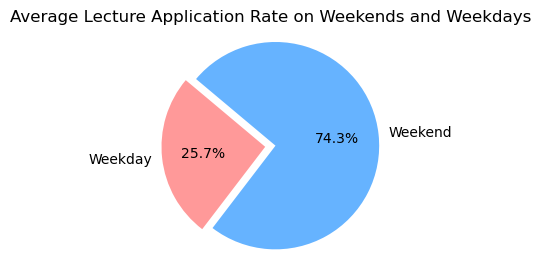

In [ ]:
# 파이차트 내용
labels = ['Weekday', 'Weekend']
sizes = [weekend_order_rate, weekday_order_rate]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

# 파이차트 생성
plt.figure(figsize=(3, 3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Average Lecture Application Rate on Weekends and Weekdays')
plt.axis('equal')
plt.show()

#### **(User) 회원 가입(created_at) 활발했던 주요 시간 분석 - 월별 차이와 그 근거 추론**

- 월별로 가장 활발한 회원가입 시간때는 1,2,12월은 13시, 3,10월은 5시, 6월은 6시, 나머지 달(4,5,7,8,9,11월)은 7시였음.
- 12월~2월에 13시에 활발히 회원가입을 한 이유는 방학기간과 연관이 있어보임
     - 보통 학교 겨울방학이 12~2월 사이이며, 사람들의 생활패턴이 평상시와 달라지기 때문으로 추정됨.
     - 늦잠을 자고 일어나 점심을 먹고 강의를 수강하는데 관심을 보였을 것이라 생각됨
     - 또한 아침 추위로 인해 사람들은 오후에 무언가를 하는 것을 선호하는 경향이 있음

In [ ]:
user.head()

,id,type,state,created_at,updated_at,last_login_at,username
0,1075089,USER,NORMAL,2022-12-31 23:39:19,2023-12-02 00:00:22,2022-12-31 23:44:35,dkfk
1,1075079,USER,NORMAL,2022-12-31 23:08:47,2023-12-03 23:34:39,2023-12-03 23:34:40,toqu
2,1075074,USER,NORMAL,2022-12-31 22:46:31,2023-10-19 11:49:10,2023-10-19 11:49:10,theh
3,1075064,USER,NORMAL,2022-12-31 22:03:14,2023-10-06 18:20:51,2023-10-06 18:20:51,tige
4,1075059,USER,NORMAL,2022-12-31 21:35:42,2023-02-17 01:54:52,2023-02-17 01:54:52,kyg6


In [ ]:
# 'created_at' 열을 datetime 형식으로 변환
user['created_at'] = pd.to_datetime(user['created_at'])

In [ ]:
## 날짜 포맷을 %Y-%m-%d 형식으로 지정.
user["created_at"] = pd.to_datetime(user["created_at"], format='%Y-%m-%d')

In [ ]:
# 월과 시간 열 생성
user['join_month'] = user['created_at'].dt.month
user['join_hour'] = user['created_at'].dt.hour

# 피벗 테이블 생성
pivot_table = user.pivot_table(index='join_month', columns='join_hour', aggfunc='size', fill_value=0)

# 피벗 테이블에서 가장 활발한 시간대 추출
monthly_active_count_hour = pivot_table.idxmax(axis=1)
monthly_active_count = pivot_table.max(axis=1)

# 모든 열 출력
pd.set_option('display.max_columns', None)

pivot_table

join_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
join_month,,,,,,,,,,,,,,,,,,,,,,,,
1,506,656,656,579,697,723,782,761,752,683,617,709,823,867,828,499,329,232,149,99,101,120,146,322
2,400,492,449,410,548,596,589,563,578,551,535,545,569,644,606,396,287,148,103,85,60,74,134,237
3,448,530,521,460,591,638,602,588,580,486,472,450,507,555,541,340,216,139,92,66,60,89,134,252
4,385,483,469,356,468,488,508,536,498,406,368,376,404,459,497,283,212,153,100,56,62,85,143,240
5,376,484,486,340,540,752,763,933,752,646,411,419,432,456,443,285,209,129,96,47,56,88,123,276
6,352,487,437,350,496,546,597,563,584,402,365,424,467,545,531,316,234,144,93,77,63,104,122,237
7,440,591,586,461,574,633,702,742,600,506,437,486,561,578,564,377,257,160,114,72,88,98,146,290
8,429,581,598,446,577,632,657,705,635,615,529,573,603,673,584,377,260,160,117,74,74,108,163,283
9,399,487,480,410,571,579,589,626,589,497,445,500,523,612,600,363,252,143,106,73,71,72,134,216


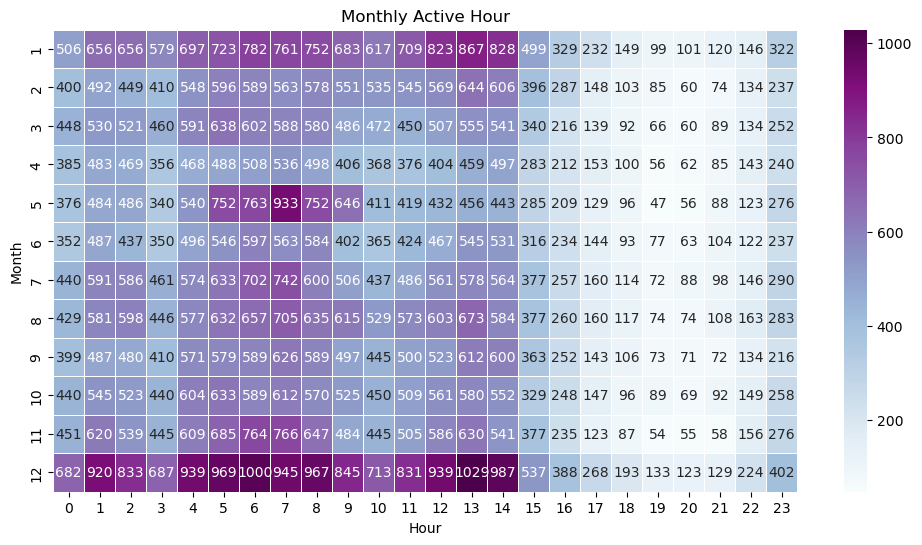

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 히트맵 형성
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="BuPu", linewidths=0.5, annot=True, fmt='d', annot_kws={"ha": 'center', "va": 'center'})
plt.title('Monthly Active Hour')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.show()

#### **(Order) 강의 가격(list_price)을 5만원 단위의 도수분포표로 분석**

- 5만원 미만 강의 가격이 267,266개로 가장 많았으며, 670만원 미만까지로 나누어 볼 수 있었음

In [ ]:
# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

# list_price 열에서 5만원 단위로 반올림하여 범주화하고, 도수분포표 생성
price_distribution = order['list_price'].apply(lambda x: (x // 50000 + 1) * 50000).value_counts().sort_index()

# 결과 출력
print("도수분포표:")
for price_range, count in price_distribution.items():
    print(f"{add_commas_and_won(price_range)}원 미만: {count}개")

도수분포표:
50,000원원 미만: 267266개
100,000원원 미만: 12565개
150,000원원 미만: 3656개
200,000원원 미만: 73개
250,000원원 미만: 172개
300,000원원 미만: 4개
350,000원원 미만: 52개
400,000원원 미만: 202개
450,000원원 미만: 5개
500,000원원 미만: 4개
550,000원원 미만: 2개
600,000원원 미만: 3개
650,000원원 미만: 3개
750,000원원 미만: 1개
850,000원원 미만: 4개
950,000원원 미만: 2개
1,150,000원원 미만: 5개
1,250,000원원 미만: 4개
1,300,000원원 미만: 1개
2,050,000원원 미만: 1개
2,550,000원원 미만: 1개
4,850,000원원 미만: 2개
5,300,000원원 미만: 3개
6,700,000원원 미만: 4개


#### **(Order) 신청이 완료된 강의(complated)와 진행중인 강의(pending), 그리고 취소된 강의(cancelled) 간의 금액(list_price)과 유저의 비중을 월별로 각각 분석**

- 전체 3가지 신청 상태에서 가장 주문금액이 낮았던 달은 공통적으로 5월이었음
- 전체 3가지 신청 상태에서 신청이 완료되거나 보류중인 강의의 주문금액이 많았던 달은 12월이었으며, 취소의 경우 1월이 가장 많았음.

#### **(1) 신청이 완료된(COMPLETED) 강의 기준 월별 유저 비중과 금액**

- 신청완료된 강의 기준으로 총 주문금액이 높았던 달은 12월로 691,980,000원이며, 유저의 비중은 27.9% 차지하였음
- 총 주문금액이 낮았던 달은 5월로 금액은 294,430,000원으로 유저는 10.6% 차지하고 있었음

In [ ]:
# 'state' 열에서 'COMPLETED'인 유저 수 계산
completed_id = len(order[order['state'] == 'COMPLETED'])

# 전체 유저 수
# 중복되지 않은 고유한 유저 id의 개수로 전체 유저 수를 계산
total_id = len(order['customer_id'].unique())

# 'state'가 'COMPLETED'인 유저의 비중 계산
completed_id_ratio = (completed_id / total_id)*100

# 콤마 추가 함수 정의
def add_commas(x):
    return '{:,}명'.format(x)

# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

print("'state'가 'COMPLETED'인 유저 수:", add_commas(completed_id))
print("'state'가 'COMPLETED'인 유저의 비중: {:.1f}%".format(completed_id_ratio))

# 'state'가 'completed'인 유저들의 총 주문 금액 계산
total_id_price = order[order['state'] == 'COMPLETED']['list_price'].sum()
print("'state'가 'COMPLETED'인 유저들의 총 주문 금액:", add_commas_and_won(total_id_price))

'state'가 'COMPLETED'인 유저 수: 176,082명
'state'가 'COMPLETED'인 유저의 비중: 173.1%
'state'가 'COMPLETED'인 유저들의 총 주문 금액: 4,828,630,000원


In [ ]:
# 월별로 'list_price'의 총 합과 'state'가 'completed'인 유저의 수 계산
monthly_total_price = order[order['state'] == 'COMPLETED'].groupby('month')['list_price'].sum()
monthly_completed_users = order[order['state'] == 'COMPLETED'].groupby('month').size()

# 월별로 'state'가 'COMPLETED'인 유저의 비중 계산
monthly_completed_id_ratio = (monthly_completed_users / total_id)*100

# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

# 결과 출력
result_completed = pd.DataFrame({
    '월별 completed된 총 주문 금액': monthly_total_price.apply(add_commas_and_won),
    '월별 completed된 유저의 비중': ['{:.1f}%'.format(ratio) for ratio in monthly_completed_id_ratio]
})

result_completed

,월별 completed된 총 주문 금액,월별 completed된 유저의 비중
month,,
1,"515,660,000원",18.1%
2,"396,660,000원",14.4%
3,"341,250,000원",11.8%
4,"326,280,000원",10.7%
5,"294,430,000원",10.6%
6,"336,600,000원",12.5%
7,"414,130,000원",14.7%
8,"370,250,000원",13.6%
9,"357,260,000원",12.9%


#### **(2) 신청이 진행중인(PENDING) 강의 기준 월별 유저 비중과 금액**

- 신청이 보류중인 강의 중 가장 총 금액이 높은 달은 12월이었으며 176,760,000원이었음. 유저는 6.4% 차지하였음
- 가장 총금액이 낮은 달은 5월로 84,820,000원이었으며, 유저는 2.9% 차지하였음.

In [ ]:
# 'state' 열에서 'PENDING'인 유저 수 계산
pending_id = len(order[order['state'] == 'PENDING'])

# 전체 유저 수
total_id = len(order['customer_id'].unique())

# 'state'가 'PENDING'인 유저의 비중 계산
pending_id_ratio = (pending_id / total_id)*100

# 콤마 추가 함수 정의
def add_commas(x):
    return '{:,}명'.format(x)

# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

print("'state'가 'PENDING'인 유저 수:", add_commas(pending_id))
print("'state'가 'PENDING'인 유저의 비중: {:.1f}%".format(pending_id_ratio))

# 'state'가 'PENDING'인 유저들의 총 주문 금액 계산
total_id_price_pending = order[order['state'] == 'PENDING']['list_price'].sum()
print("'state'가 'PENDING'인 유저들의 총 주문 금액:", add_commas_and_won(total_id_price_pending))

'state'가 'PENDING'인 유저 수: 49,806명
'state'가 'PENDING'인 유저의 비중: 49.0%
'state'가 'PENDING'인 유저들의 총 주문 금액: 1,420,700,000원


In [ ]:
# 월별로 'list_price'의 총 합과 'state'가 'PENDING'인 유저의 수 계산
monthly_total_price = order[order['state'] == 'PENDING'].groupby('month')['list_price'].sum()
monthly_pending_users = order[order['state'] == 'PENDING'].groupby('month').size()

# 월별로 'state'가 'PENDING'인 유저의 비중 계산
monthly_pending_id_ratio = (monthly_pending_users / total_id)*100

# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

# 결과 출력
result_pending = pd.DataFrame({
    '월별 PENDING된 총 주문 금액': monthly_total_price.apply(add_commas_and_won),
    '월별 PENDING된 유저의 비중': ['{:.1f}%'.format(ratio) for ratio in monthly_pending_id_ratio]
})

result_pending

,월별 PENDING된 총 주문 금액,월별 PENDING된 유저의 비중
month,,
1,"157,970,000원",5.3%
2,"101,860,000원",3.7%
3,"95,090,000원",3.3%
4,"106,080,000원",3.2%
5,"84,820,000원",2.9%
6,"102,510,000원",3.8%
7,"124,670,000원",3.9%
8,"149,980,000원",5.6%
9,"115,070,000원",4.0%


#### **(3) 신청이 취소된 강의(CANCELLED) 강의 기준 월별 유저 비중과 금액**

- 신청이 취소된 강의를 대상으로 분석했을 때 1월이 218,380,000원으로 가장 금액이 높았으며, 유저의 약 6.9%를 차지하였음
- 가장 낮은 금액을 기록한 것은 5월로 105,310,000원이었고, 유저의 3.3%를 차지하였음

In [ ]:
# 'state' 열에서 'CANCELLED'인 유저 수 계산
CANCELLED_id = len(order[order['state'] == 'CANCELLED'])

# 전체 유저 수
total_id = len(order['customer_id'].unique())

# 'state'가 'CANCELLED'인 유저의 비중 계산
CANCELLED_id_ratio = (CANCELLED_id / total_id)*100

# 콤마 추가 함수 정의
def add_commas(x):
    return '{:,}명'.format(x)

# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

print("'state'가 'CANCELLED'인 유저 수:", add_commas(CANCELLED_id))
print("'state'가 'CANCELLED'인 유저의 비중: {:.1f}%".format(CANCELLED_id_ratio))

# 'state'가 'CANCELLED'인 유저들의 총 주문 금액 계산
total_id_price_CANCELLED = order[order['state'] == 'CANCELLED']['list_price'].sum()
print("'state'가 'CANCELLED'인 유저들의 총 주문 금액:", add_commas_and_won(total_id_price_CANCELLED))

'state'가 'CANCELLED'인 유저 수: 58,147명
'state'가 'CANCELLED'인 유저의 비중: 57.2%
'state'가 'CANCELLED'인 유저들의 총 주문 금액: 1,780,780,000원


In [ ]:
# 월별로 'list_price'의 총 합과 'state'가 'CANCELLED'인 유저의 수 계산
monthly_CANCELLED_total_price = order[order['state'] == 'CANCELLED'].groupby('month')['list_price'].sum()
monthly_CANCELLED_users = order[order['state'] == 'CANCELLED'].groupby('month').size()

# 월별로 'state'가 'PENDING'인 유저의 비중 계산
monthly_CANCELLED_id_ratio = (monthly_CANCELLED_users / total_id)*100

# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

# 결과 출력
result_CANCELLED = pd.DataFrame({
    '월별 CANCELLED된 총 주문 금액': monthly_CANCELLED_total_price.apply(add_commas_and_won),
    '월별 CANCELLED된 유저의 비중': ['{:.1f}%'.format(ratio) for ratio in monthly_CANCELLED_id_ratio]
})

result_CANCELLED

,월별 CANCELLED된 총 주문 금액,월별 CANCELLED된 유저의 비중
month,,
1,"218,380,000원",6.9%
2,"140,410,000원",4.9%
3,"138,870,000원",4.5%
4,"132,670,000원",3.9%
5,"105,310,000원",3.3%
6,"126,730,000원",4.3%
7,"166,920,000원",4.8%
8,"142,310,000원",5.0%
9,"149,670,000원",5.0%


#### **(User) state이 HIBERNATED 된 Used들이 ID를 생성(created_at)한 후 마지막 로그인(last_login_at)까지 평균적으로 걸린 일자 분석**

- 평균적으로 id를 생성한 후 마지막 로그인까지 154일이 걸렸음

In [ ]:
user.head()

,id,type,state,created_at,updated_at,last_login_at,username,join_month,join_hour
0,1075089,USER,NORMAL,2022-12-31 23:39:19,2023-12-02 00:00:22,2022-12-31 23:44:35,dkfk,12,23
1,1075079,USER,NORMAL,2022-12-31 23:08:47,2023-12-03 23:34:39,2023-12-03 23:34:40,toqu,12,23
2,1075074,USER,NORMAL,2022-12-31 22:46:31,2023-10-19 11:49:10,2023-10-19 11:49:10,theh,12,22
3,1075064,USER,NORMAL,2022-12-31 22:03:14,2023-10-06 18:20:51,2023-10-06 18:20:51,tige,12,22
4,1075059,USER,NORMAL,2022-12-31 21:35:42,2023-02-17 01:54:52,2023-02-17 01:54:52,kyg6,12,21


In [ ]:
# 'created_at' 열과 'last_login_at' 열을 datetime 형식으로 변환
user['created_at'] = pd.to_datetime(user['created_at'])
user['last_login_at'] = pd.to_datetime(user['last_login_at'])

# 'state'가 'HIBERNATED'인 사용자들만 필터링
hibernated_users = user[user['state'] == 'HIBERNATED']

# ID 생성일(created_at)부터 마지막 로그인일(last_login_at)까지의 기간 계산 및 새로운 열 추가
hibernated_users['duration'] = hibernated_users['last_login_at'] - hibernated_users['created_at']

hibernated_users

/var/folders/hb/f1y5nz6507d61r_qtd_nvw6r0000gn/T/ipykernel_1011/4103149316.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hibernated_users['duration'] = hibernated_users['last_login_at'] - hibernated_users['created_at']


,id,type,state,created_at,updated_at,last_login_at,username,join_month,join_hour,duration
4112,1060441,USER,HIBERNATED,2022-12-22 02:47:50,2023-12-22 03:00:26,2022-12-22 02:47:51,fire,12,2,0 days 00:00:01
4115,1060433,USER,HIBERNATED,2022-12-22 02:35:53,2023-12-22 03:00:26,2022-12-22 02:35:53,dlsd,12,2,0 days 00:00:00
4121,1060422,USER,HIBERNATED,2022-12-22 02:30:07,2023-12-22 03:00:26,2022-12-22 02:30:22,ever,12,2,0 days 00:00:15
4123,1060418,USER,HIBERNATED,2022-12-22 02:28:07,2023-12-22 03:00:26,2022-12-22 02:35:29,yong,12,2,0 days 00:07:22
4124,1060415,USER,HIBERNATED,2022-12-22 02:23:09,2023-12-22 03:00:26,2022-12-22 02:28:48,ssm7,12,2,0 days 00:05:39
...,...,...,...,...,...,...,...,...,...,...
122961,1201,USER,HIBERNATED,2019-09-24 01:05:27,2023-03-05 12:00:16,2022-03-05 09:37:15,cngh,9,1,893 days 08:31:48
122966,1160,USER,HIBERNATED,2019-09-23 14:04:23,2024-01-26 00:00:22,2023-01-18 05:03:44,eekb,9,14,1212 days 14:59:21
122970,1118,USER,HIBERNATED,2019-09-23 09:56:12,2023-01-27 12:02:55,2022-01-27 09:14:54,ands,9,9,856 days 23:18:42
122971,1115,USER,HIBERNATED,2019-09-23 09:38:25,2023-08-29 18:00:18,2022-08-29 12:19:44,toyt,9,9,1071 days 02:41:19


/var/folders/hb/f1y5nz6507d61r_qtd_nvw6r0000gn/T/ipykernel_1011/3686352905.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hibernated_users['duration_days'] = (pd.to_datetime(hibernated_users['last_login_at']) - pd.to_datetime(hibernated_users['created_at'])).dt.days


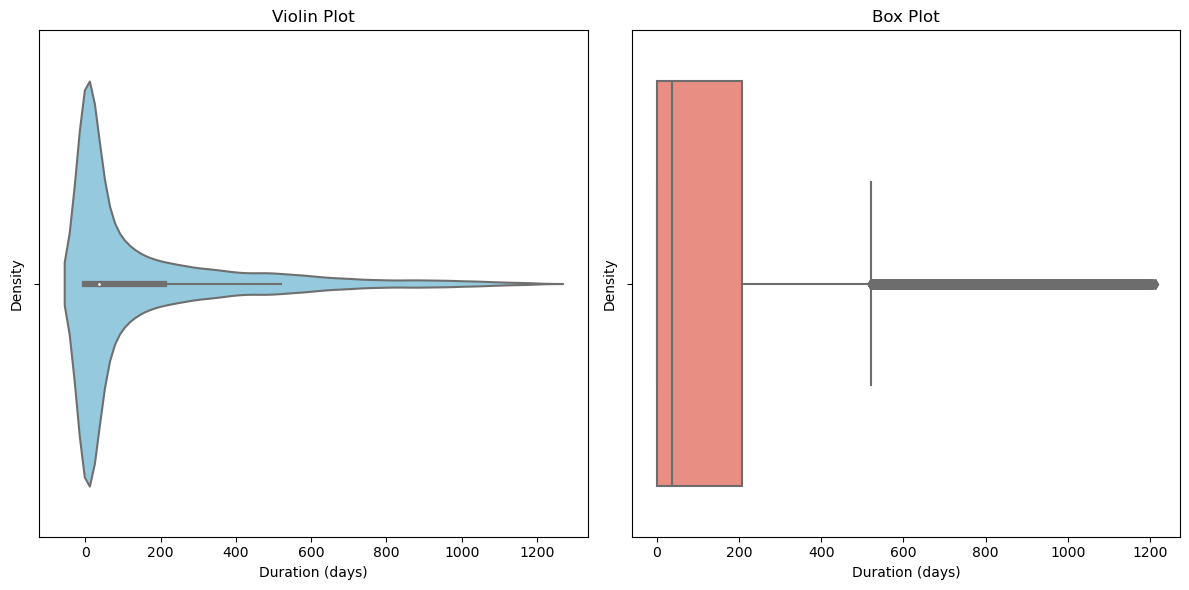

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# HIBERNATED 상태인 사용자들의 활동 기간을 일 단위로 계산하여 데이터프레임 생성
hibernated_users = user[user['state'] == 'HIBERNATED']
hibernated_users['duration_days'] = (pd.to_datetime(hibernated_users['last_login_at']) - pd.to_datetime(hibernated_users['created_at'])).dt.days

# 바이올린 플롯과 박스 플롯 함께 그리기
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='duration_days', data=hibernated_users, color='skyblue')
plt.title('Violin Plot')
plt.xlabel('Duration (days)')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.boxplot(x='duration_days', data=hibernated_users, color='salmon')
plt.title('Box Plot')
plt.xlabel('Duration (days)')
plt.ylabel('Density')

# subplot 간 간격 조정
plt.tight_layout()
plt.show()

In [ ]:
average_duration = hibernated_users['last_login_at'] - hibernated_users['created_at']
print("평균 접속일:", average_duration.mean())

평균 접속일: 154 days 11:33:28.358140552


## **Trend Analysis**

### **4) 2022년 1월부터 12월까지 trend 분석**

####  **(order 데이터) 월별 강의 가격(list_price)과 판매가격(sale_price) 비교**

- order 데이터는 2022년 데이터로만 이루어져 있었음
- 강의 가격(list_price)과 판매가격(sale_price)를 비교했을 때 두 가격 간의 차이가 12월(348,080,000원)이 가장 컸으며, 6월(57,600,000원)이 가장 작았음

In [ ]:
order.head()

,id,type,state,name,created_at,month,day,weekday,updated_at,customer_id,list_price,sale_price,discount_price,tax_free_price
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,12,31,Saturday,2022-12-31 23:42:52,1083679,10000,0,10000,0
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,12,31,Saturday,2022-12-31 23:39:25,129176,40000,40000,0,40000
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,12,31,Saturday,2022-12-31 23:39:17,1072552,20000,10000,10000,10000
3,1600577,ORDER,COMPLETED,백엔드 개발자를 위,2022-12-31 23:35:52,12,31,Saturday,2022-12-31 23:36:09,1083664,20000,20000,10000,20000
4,1600574,ORDER,COMPLETED,React Nati,2022-12-31 23:30:51,12,31,Saturday,2022-12-31 23:31:13,1033553,20000,20000,0,20000


In [ ]:
print(order["created_at"].min())
print(order["created_at"].max())

2022-01-01 00:08:19
2022-12-31 23:42:49


In [ ]:
order[["id", "month", "sale_price"]].head()

,id,month,sale_price
0,1600585,12,0
1,1600580,12,40000
2,1600579,12,10000
3,1600577,12,20000
4,1600574,12,20000


In [ ]:
monthly_data = pd.pivot_table(order, index='month', values=['list_price','sale_price', 'discount_price'], aggfunc='sum')

# 콤마 및 원 표시 함수 정의
def add_commas_and_won(x):
    return '{:,.0f}원'.format(x)

# 천원 콤마, 원 표시 적용
monthly_data_format = monthly_data.applymap(add_commas_and_won)

monthly_data_format

,discount_price,list_price,sale_price
month,,,
1,"215,690,000원","892,010,000원","752,110,000원"
2,"162,770,000원","638,930,000원","522,490,000원"
3,"122,360,000원","575,210,000원","503,870,000원"
4,"109,240,000원","565,030,000원","497,270,000원"
5,"127,200,000원","484,560,000원","416,870,000원"
6,"106,710,000원","565,840,000원","508,240,000원"
7,"166,070,000원","705,720,000원","604,920,000원"
8,"163,210,000원","662,540,000원","592,520,000원"
9,"133,730,000원","622,000,000원","565,350,000원"


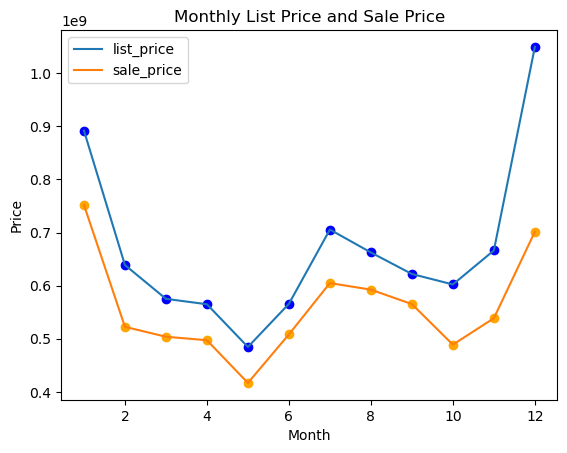

In [ ]:
plt.plot(monthly_data.index, monthly_data['list_price'], label='list_price')
plt.plot(monthly_data.index, monthly_data['sale_price'], label='sale_price')

# 월별 데이터 위치에 점 추가
plt.scatter(monthly_data.index, monthly_data['list_price'], color='blue')
plt.scatter(monthly_data.index, monthly_data['sale_price'], color='orange')

plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Monthly List Price and Sale Price')
plt.legend()

plt.show()

#### **(course 데이터) 월별 진행중인(Ongoing) 강의와 보류중인(Pending) 강의 비교**

- course 데이터는 2018년부터 2022년까지 있었기 때문에 2022년 데이터만 필터링하여 분석함
- 2022년 기준 보류중인(pending) id보다 강의 수강을 진행중인(ongoing) id가 많음을 알 수 있었음

In [ ]:
course.head()

,id,type,state,created_at,updated_at,title,description,close_at,total_class_hours,keywords
0,214903,COURSE,ONGOING,2022-12-27 1:33,2022-12-27 1:33,(B2G) K-Di-214903,NaN,NaN,NaN,NaN
1,214898,COURSE,ONGOING,2022-12-26 12:25,2022-12-26 12:25,(B2G) K-Di-214898,NaN,NaN,NaN,NaN
2,214897,COURSE,ONGOING,2022-12-26 12:20,2022-12-26 12:20,(B2G) K-Di-214897,NaN,NaN,NaN,NaN
3,214896,COURSE,ONGOING,2022-12-26 12:17,2022-12-26 12:17,(B2G) K-Di-214896,NaN,NaN,NaN,NaN
4,214895,COURSE,ONGOING,2022-12-26 12:14,2022-12-26 12:14,(B2G) K-Di-214895,NaN,NaN,NaN,NaN


In [ ]:
course["id"].count()

722

In [ ]:
print(course["created_at"].min())
print(course["created_at"].max())

2018-05-03 1:19
2022-12-27 1:33


In [ ]:
course["created_at"] = pd.to_datetime(course["created_at"])
course["created_month"] = course["created_at"].dt.strftime("%Y-%m")
course[["id","state","created_month"]].head()

,id,state,created_month
0,214903,ONGOING,2022-12
1,214898,ONGOING,2022-12
2,214897,ONGOING,2022-12
3,214896,ONGOING,2022-12
4,214895,ONGOING,2022-12


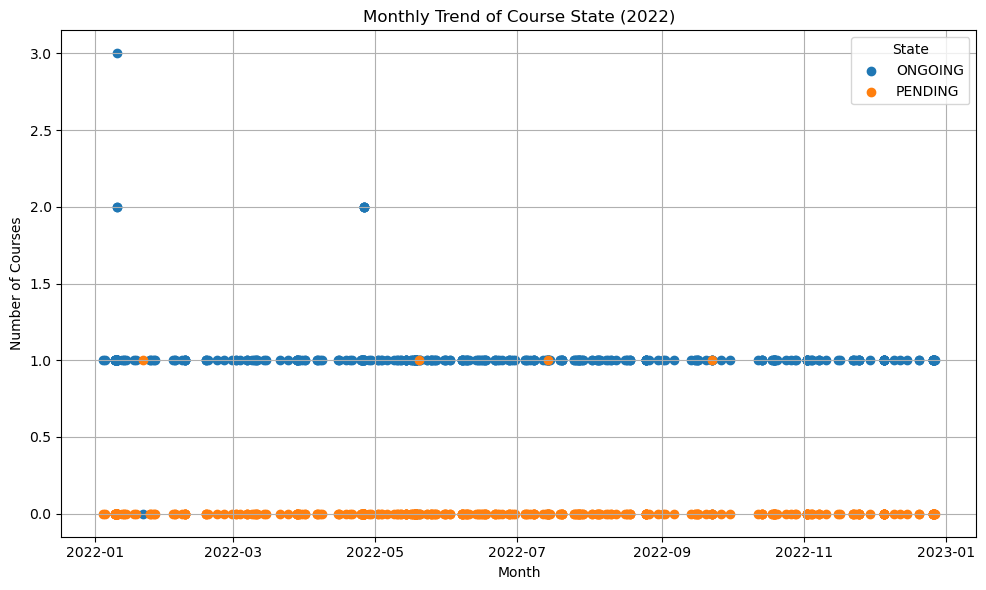

In [ ]:
# 2022년 1월부터 12월까지의 데이터만 필터링
course_filtered = course[(course['created_at'] >= '2022-01-01') & (course['created_at'] <= '2022-12-31')]

# 'ONGOING'와 'PENDING' 상태인 경우에 해당하는 데이터만 필터링
course_filtered = course_filtered[(course_filtered['state'] == 'ONGOING') | (course_filtered['state'] == 'PENDING')]

# 월별로 강의가 진행중인 ID의 총 개수 계산
monthly_counts = course_filtered.groupby(['created_at', 'state']).size().unstack(fill_value=0)

# 각 상태별로 월별 강의 개수를 점 그래프로 표현합니다.
fig, ax = plt.subplots(figsize=(10, 6))

for state in monthly_counts.columns:
    ax.scatter(monthly_counts.index, monthly_counts[state], label=state, marker='o')

# 그래프 꾸미기
plt.title('Monthly Trend of Course State (2022)')
plt.xlabel('Month')
plt.ylabel('Number of Courses')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()

# 그래프 표시
plt.show()

#### **(user 데이터) 가입 후 마지막 로그인날까지 기간**

- 2022년 기준으로 했을 때 USER들은 신규가입 후 마지막 로그인날까지 50일(46일 정도)이 되지 않았을 때 다시 접속하는 것을 알 수 있음
- 최대 350일까지 다시 접속하는데 걸린 유저들은 210명 정도로 매우 적음

In [ ]:
user.head()

,id,type,state,created_at,updated_at,last_login_at,username,join_month,join_hour
0,1075089,USER,NORMAL,2022-12-31 23:39:19,2023-12-02 00:00:22,2022-12-31 23:44:35,dkfk,12,23
1,1075079,USER,NORMAL,2022-12-31 23:08:47,2023-12-03 23:34:39,2023-12-03 23:34:40,toqu,12,23
2,1075074,USER,NORMAL,2022-12-31 22:46:31,2023-10-19 11:49:10,2023-10-19 11:49:10,theh,12,22
3,1075064,USER,NORMAL,2022-12-31 22:03:14,2023-10-06 18:20:51,2023-10-06 18:20:51,tige,12,22
4,1075059,USER,NORMAL,2022-12-31 21:35:42,2023-02-17 01:54:52,2023-02-17 01:54:52,kyg6,12,21


In [ ]:
print(user["created_at"].min())
print(user["created_at"].max())

2019-07-01 23:49:35
2022-12-31 23:39:19


In [ ]:
print(user["last_login_at"].min())
print(user["last_login_at"].max())

2021-11-14 12:00:19
2024-01-26 02:03:42


/var/folders/hb/f1y5nz6507d61r_qtd_nvw6r0000gn/T/ipykernel_1011/3884733130.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hibernated_users['duration'] = (hibernated_users['last_login_at'] - hibernated_users['created_at']).dt.days


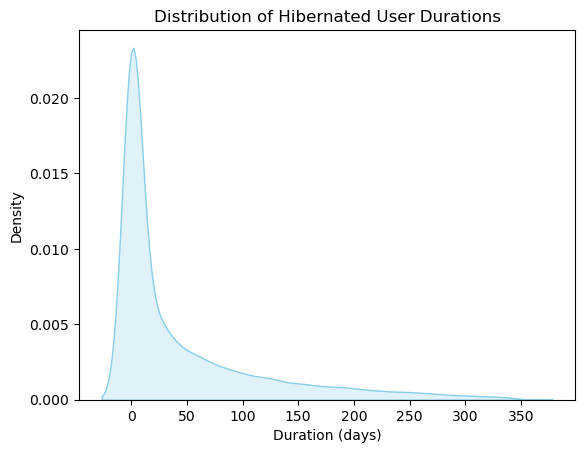

Average duration until last login: 46.3 days


In [ ]:
# 2022년 1월부터 12월까지의 데이터만 필터링
user_filtered = user[(user['created_at'] >= '2022-01-01') & (user['created_at'] <= '2022-12-31')]

# 'state'가 'HIBERNATED'인 사용자들만 필터링
hibernated_users = user_filtered[user_filtered['state'] == 'HIBERNATED']

# ID 생성일(created_at)부터 마지막 로그인일(last_login_at)까지의 기간 계산 및 새로운 열 추가
hibernated_users['duration'] = (hibernated_users['last_login_at'] - hibernated_users['created_at']).dt.days

# last_login_at와 created_at이 동일한 경우에는 duration을 0으로 설정
hibernated_users.loc[hibernated_users['last_login_at'] == hibernated_users['created_at'], 'duration'] = 0

# KDE 플롯 그리기
sns.kdeplot(hibernated_users['duration'], shade=True, color='skyblue')

# 그래프 꾸미기
plt.title('Distribution of Hibernated User Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Density')

# 그래프 표시
plt.show()


# 평균적인 재접속일 구하기
average_duration = hibernated_users['duration'].mean()

# 결과 출력
print("Average duration until last login: {:.1f} days".format(average_duration))

#### **(customer 데이터) 월별 가입 유저수 추세**

- 1월 9332명, 12월 8587명 순으로 가장 많은 가입을 했음음 볼 수 있었으며, 가장 가입 유저가 적었던 달은 5월로 5,185명이었음
- 전체적으로 1월에서 5월 사이는 하락세를 보였고, 5월에서 8월까지는 다시 상승하지만 8월~11월까지 다시 하락세를 보였음

In [ ]:
customer.head()

,id,type,state,created_at,updated_at,user_id,name,phone,email
0,1482394,USER,NORMAL,2024/01/24 4:44,2024/01/24 13:54,959919,USER_1482394,1012345678,USER_1482394@notexistemail.com
1,1482300,USER,NORMAL,2024/01/24 4:43,2024/01/25 6:10,818301,USER_1482300,1012345678,USER_1482300@notexistemail.com
2,1482071,USER,NORMAL,2024/01/24 4:41,2024/01/25 7:46,543671,USER_1482071,1012345678,USER_1482071@notexistemail.com
3,1445268,USER,NORMAL,2023/12/27 4:17,2023/12/27 4:17,824733,USER_1445268,1012345678,USER_1445268@notexistemail.com
4,1445150,USER,NORMAL,2023/12/27 4:15,2023/12/27 4:15,767404,USER_1445150,1012345678,USER_1445150@notexistemail.com


In [ ]:
print(customer["created_at"].min())
print(customer["created_at"].max())

2015/02/14 15:00
2024/01/24 4:44


In [ ]:
print(customer["updated_at"].min())
print(customer["updated_at"].max())

2019/09/18 0:55
2024/01/26 0:00


In [ ]:
# 'created_at' 열과 'updated_at' 열을 datetime 형식으로 변환
customer['created_at'] = pd.to_datetime(customer['created_at'])
customer['updated_at'] = pd.to_datetime(customer['updated_at'])

# 가입일(created_at)부터 이후 수정일(updated_at)까지의 기간을 계산하여 새로운 열 추가
customer['days_since_creation'] = (customer['updated_at'] - customer['created_at']).dt.days

# 결과 출력
customer.head()

,id,type,state,created_at,updated_at,user_id,name,phone,email,days_since_creation
0,1482394,USER,NORMAL,2024-01-24 04:44:00,2024-01-24 13:54:00,959919,USER_1482394,1012345678,USER_1482394@notexistemail.com,0
1,1482300,USER,NORMAL,2024-01-24 04:43:00,2024-01-25 06:10:00,818301,USER_1482300,1012345678,USER_1482300@notexistemail.com,1
2,1482071,USER,NORMAL,2024-01-24 04:41:00,2024-01-25 07:46:00,543671,USER_1482071,1012345678,USER_1482071@notexistemail.com,1
3,1445268,USER,NORMAL,2023-12-27 04:17:00,2023-12-27 04:17:00,824733,USER_1445268,1012345678,USER_1445268@notexistemail.com,0
4,1445150,USER,NORMAL,2023-12-27 04:15:00,2023-12-27 04:15:00,767404,USER_1445150,1012345678,USER_1445150@notexistemail.com,0


In [ ]:
customer["created_month"] = customer["created_at"].dt.strftime("%Y%m")

In [ ]:
# 2022년 1월부터 12월까지 데이터만 필터링
customer_filtered = customer[(customer['created_at'] >= '2022-01-01') & (customer['created_at'] <= '2022-12-31')]

# 월별로 user_id의 개수를 카운팅하여 새로운 열 추가
count_by_month = customer_filtered.groupby(customer_filtered['created_at'].dt.strftime('%Y-%m'))['user_id'].count().reset_index()
count_by_month.columns = ['created_month', 'user_count']

# 결과 출력
count_by_month

,created_month,user_count
0,2022-01,9332
1,2022-02,6058
2,2022-03,6294
3,2022-04,5310
4,2022-05,5185
5,2022-06,5707
6,2022-07,6967
7,2022-08,7570
8,2022-09,6691
9,2022-10,5676


Monthly User Count:
+----+-----------------+--------------+
|    | created_month   |   user_count |
+====+=================+==============+
|  0 | 2022-01         |         9332 |
+----+-----------------+--------------+
|  1 | 2022-02         |         6058 |
+----+-----------------+--------------+
|  2 | 2022-03         |         6294 |
+----+-----------------+--------------+
|  3 | 2022-04         |         5310 |
+----+-----------------+--------------+
|  4 | 2022-05         |         5185 |
+----+-----------------+--------------+
|  5 | 2022-06         |         5707 |
+----+-----------------+--------------+
|  6 | 2022-07         |         6967 |
+----+-----------------+--------------+
|  7 | 2022-08         |         7570 |
+----+-----------------+--------------+
|  8 | 2022-09         |         6691 |
+----+-----------------+--------------+
|  9 | 2022-10         |         5676 |
+----+-----------------+--------------+
| 10 | 2022-11         |         5734 |
+----+--------------

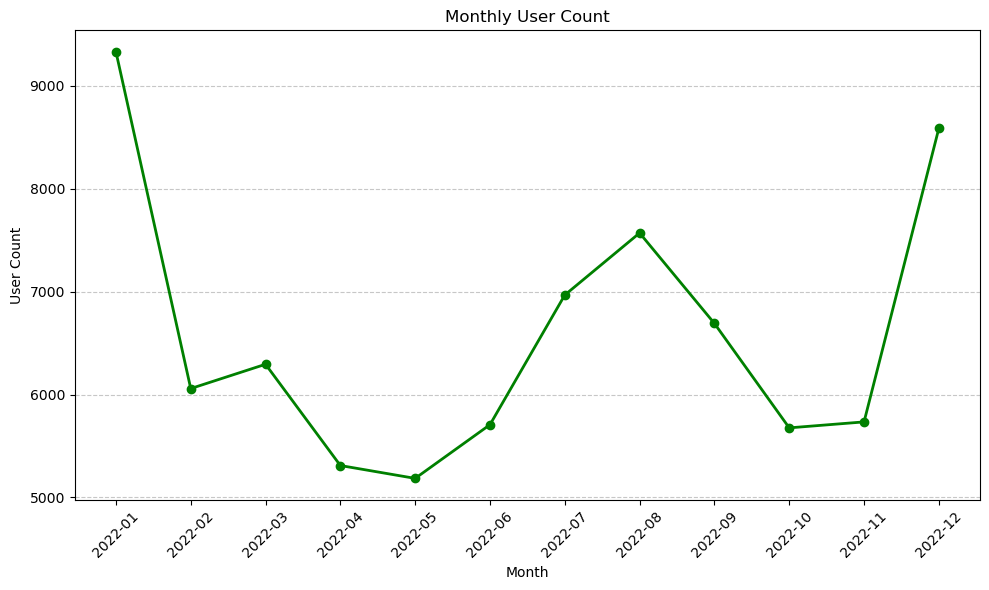

In [ ]:
from tabulate import tabulate

# 데이터프레임 생성
count_by_month = customer_filtered.groupby(customer_filtered['created_at'].dt.strftime('%Y-%m'))['user_id'].count().reset_index()
count_by_month.columns = ['created_month', 'user_count']

# 테이블 출력
print("Monthly User Count:")
print(tabulate(count_by_month, headers='keys', tablefmt='grid'))

# 그래프 출력
plt.figure(figsize=(10, 6))
plt.plot(count_by_month['created_month'], count_by_month['user_count'], marker='o', color='green', linewidth=2)
plt.title('Monthly User Count')
plt.xlabel('Month')
plt.ylabel('User Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **(refund 데이터) 월별 환불 강의수와 금액 분석**

- REFUND 데이터는 2022년 1월 3일부터 12월 30일까지 구성되었으며, state가 completed되었으며, type이 ADMIN_AUTO_REFUND 데이터만 존재하였음
- 환불은 1월과 12월에 많이 일어났으며, 그 금액도 2,300,000원 이상이었음. 적은 달은 3월로 774개 강의가 14,900,000원 환불되었음
- 반면 10월에는 906개 강의가 환불되었지만 그 금액은 14,990,000원으로 적은 액수가 환불되었음

In [ ]:
refund.head()

,id,type,state,created_at,updated_at,user_id,course_id,amount,tax_free_amount
0,72124,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 7:29,2022-12-30 7:29,619833.0,214323.0,-20000,-20000
1,72121,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 7:01,2022-12-30 7:01,146614.0,213905.0,-10000,-10000
2,72119,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 6:08,2022-12-30 6:08,541404.0,214402.0,0,0
3,72117,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 6:00,2022-12-30 6:00,1056095.0,203935.0,-10000,-10000
4,72116,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 5:57,2022-12-30 5:57,98880.0,213244.0,-20000,-20000


In [ ]:
print(refund["created_at"].min())
print(refund["created_at"].max())

2022-01-03 1:04
2022-12-30 7:29


In [ ]:
# state 열의 고유값 확인
state_refund = refund['state'].unique()

# 결과 출력
print(state_refund)

['COMPLETED']


In [ ]:
# type 열의 고유값 확인
type_refund = refund['type'].unique()

# 결과 출력
print(type_refund)

['ADMIN_AUTO_REFUND']


In [ ]:
refund["created_at"] = pd.to_datetime(refund["created_at"])
refund.insert(loc=5, column ='created_month', value=refund.created_at.dt.month)

In [ ]:
# 'created_month'를 기준으로 'course_id'와 'amount' 합계 계산
refund_df = refund.groupby('created_month').agg({'course_id': 'count', 'amount': 'sum'})

# 천단위 표시 함수 정의
def add_commas(x):
    return '{:,.0f}'.format(x)

# 천단위 표시 적용
refund_df_format = refund_df.applymap(add_commas)

refund_df_format

,course_id,amount
created_month,,
1,"1,369","-23,490,000"
2,"1,066","-17,940,000"
3,774,"-14,900,000"
4,892,"-18,660,000"
5,802,"-15,450,000"
6,908,"-15,440,000"
7,957,"-17,960,000"
8,983,"-15,740,000"
9,"1,074","-19,110,000"


<Figure size 1000x600 with 0 Axes>

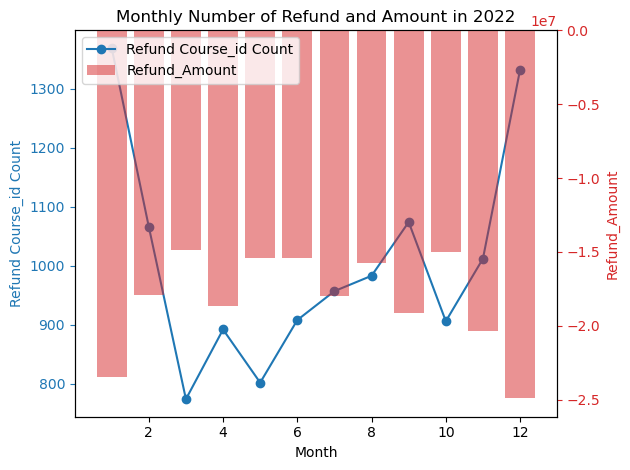

In [ ]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 그래프 그리기
fig, ax1 = plt.subplots()

# refund course_id 수 선 그래프
ax1.plot(refund_df.index, refund_df['course_id'], color='tab:blue', marker='o', label='Refund Course_id Count')
ax1.set_xlabel('Month', fontsize=10)
ax1.set_ylabel('Refund Course_id Count', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')

# refund amount 합계 바 그래프
ax2 = ax1.twinx()
ax2.bar(refund_df.index, refund_df['amount'], color='tab:red', alpha=0.5, label='Refund_Amount')
ax2.set_ylabel('Refund_Amount', color='tab:red')
ax2.tick_params('y', colors='tab:red')

# 그래프 제목 설정
plt.title('Monthly Number of Refund and Amount in 2022')

# 범례 표시
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# 그래프 표시
plt.tight_layout()
plt.show()

## (추가) 유저들의 가입특성과 수강현황 분석 결과
- 가입수가 2020년부터 급격하게 증가추세를 보였음 (2019-2020년 72명 증가 -> 2020-2021년 104명 증가 -> 2021-2022명 251명 증가)
- 유저들의 유형을 살펴보면 강좌(course) 수강을 교재(book) 수강보다 선호함을 알 수 있었음 (18배 차이)
- 전체 유저들의 수강상태에서 이미 강좌가 끝난 수가 541명으로 가장 많았음.
- 보통 유저들은 총 강의수강시간이 10시간 이상 50시간 미만 강의를 많이 수강하는 것으로 나타남 (43.5%)
- 유저들은 강의 신청시 "평생소장"이란 단어가 포함되어 있는 것에 관심이 많음을 알 수 있음

In [ ]:
!pip install IPython

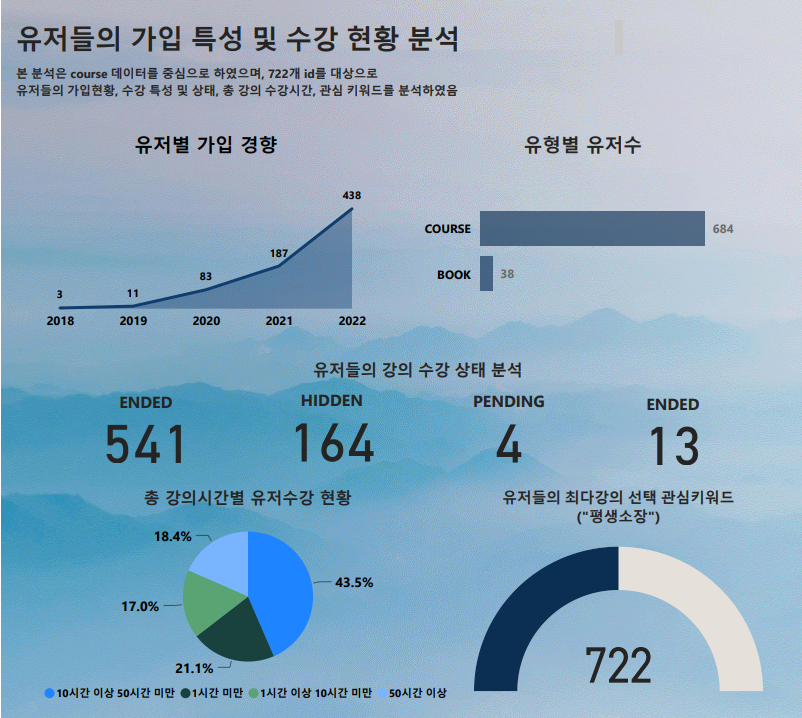

In [ ]:
from IPython.display import Image

Image('Customer Analysis.png')

# **Conclusion**

## **3. 분석종합 및 결론**

### **1) 분석 종합**

**- (Order) 2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일의 매출액(list_price)과, 주문 수, 신청자 수, 강의 수**
  -	가장 매출이 높았던 3일
   - 2022-01-03 48,980,000원, 2022-01-07 34,700,000원, 2022-01-05 33,840,000원
   - 주문 수: 3,876개, 신청자 수: 4,444명, 강의 수: 971개
  -	가장 매출이 낮았던 3일
   - 2022-01-01 6,260,000원, 2022-01-22 ,685,000원, 2022-01-29 , 89,200원
   - 주문 수: 703개, 신청 수:787명 강의수:174개

**- (Order) 월별 각 강의 별 할인율 분석**
  - 각 월별 각 강의별 할인율을 계산하였으며, 그 중 가장 높은 할인율을 가진 강의는 '[내부용]Apach' 으로 할인율은 200000.0.

**- (Course) 강의 키워드에서 가장 많이 언급된 단어 분석**
   - 강의 키워드 열에서 많이 언급된 단어를 찾기 위해서는 'keywords' 열을 토큰화하여서 가장 많이 언급되고 있는 단어를 찾아야 함
   - 'keywords' 열에서 가장 많이 언급된 단어가 ','로 나타났지만, 글자가 아니기 때문에, 두번째로 많이 언급되는 단어를 구하는 코드를 사용하였으며, '평생소장'이 86회로 가장 많이 언급된 단어로 볼 수 있음

**- (Refund) 환불이 가장 많은 강의 분석**
  -	환불이 많았던 강의 ID는 213368이며, 269회 환불되었었음.

**- (Customer) 강의를 가장 많이 신청한 고객과 그 금액 분석**
  - 강의를 많이 신청한 고객의 ID는 819532였으며, 총 669만원을 지불하였음.

**- (Order) 주말과 주중의 평균 강의 신청율 차이**
  -	주중에 고객들이 주말보다 약 3배 정도 많이 신청하는 것을 알 수 있었음
  - 주말 강의 신청율: 25.72%, 주중 강의 신청율: 74.28%

**- (User) 회원 가입(created_at) 활발했던 주요 시간 분석 - 월별 차이와 그 근거 추론**
  - 월별로 가장 활발한 회원가입 시간때는 1,2,12월은 13시, 3,10월은 5시, 6월은 6시, 나머지 달(4,5,7,8,9,11월)은 7시였음.
  - 12월~2월에 13시에 활발히 회원가입을 한 이유는 방학기간과 연관이 있어보임
  - 보통 학교 겨울방학이 12~2월 사이이며, 사람들의 생활패턴이 평상시와 달라지기 때문으로 추정됨.
  - 늦잠을 자고 일어나 점심을 먹고 강의를 수강하는데 관심을 보였을 것이라 생각됨
  - 또한 아침 추위로 인해 사람들은 오후에 무언가를 하는 것을 선호하는 경향이 있음

**- (Order) 강의 가격(list_price)을 5만원 단위의 도수분포표로 분석**
  - 5만원 미만 강의 가격이 267,266개로 가장 많았으며, 670만원 미만까지로 나누어 볼 수 있었음

**- (Order) 신청이 완료된 강의(complated)와 진행중인 강의(pending), 그리고 취소된 강의(cancelled) 간의 금액(list_price)과 유저의 비중을 월별로 각각 분석**
  - 전체 3가지 신청 상태에서 가장 주문금액이 낮았던 달은 공통적으로 5월이었음
  - 전체 3가지 신청 상태에서 신청이 완료되거나 보류중인 강의의 주문금액이 많았던 달은 12월이었으며, 취소의 경우 1월이 가장 많았음.

   - (1) 신청이 완료된(COMPLETED) 강의 기준 월별 유저 비중과 금액
     - 신청완료된 강의 기준으로 총 주문금액이 높았던 달은 12월로 691,980,000원이며, 유저의 비중은 27.9% 차지하였음
     - 총 주문금액이 낮았던 달은 5월로 금액은 294,430,000원으로 유저는 10.6% 차지하고 있었음
   - (2) 신청이 진행중인(PENDING) 강의 기준 월별 유저 비중과 금액
     - 신청이 보류중인 강의 중 가장 총 금액이 높은 달은 12월이었으며 176,760,000원이었음. 유저는 6.4% 차지하였음
     - 가장 총금액이 낮은 달은 5월로 84,820,000원이었으며, 유저는 2.9% 차지하였음.
   - (3) 신청이 취소된 강의(CANCELLED) 강의 기준 월별 유저 비중과 금액
     -	신청이 취소된 강의를 대상으로 분석했을 때 1월이 218,380,000원으로 가장 금액이 높았으며, 유저의 약 6.9%를 차지하였음
     - 가장 낮은 금액을 기록한 것은 5월로 105,310,000원이었고, 유저의 3.3%를 차지하였음

- (User) state이 HIBERNATED 된 Used들이 ID를 생성(created_at)한 후 마지막 로그인(last_login_at)까지 평균적으로 걸린 일자 분석
  - 평균적으로 id를 생성한 후 마지막 로그인까지 154일이 걸렸음

**- 2022년 1월부터 12월까지 trend 분석**
- (order 데이터) 월별 강의 가격(list_price)과 판매가격(sale_price) 비교
  -	order 데이터는 2022년 데이터로만 이루어져 있었음
  - 강의 가격(list_price)과 판매가격(sale_price)를 비교했을 때 두 가격 간의 차이가 12월(348,080,000원)이 가장 컸으며, 6월(57,600,000원)이 가장 작았음
- (course 데이터) 월별 진행중인(Ongoing) 강의와 보류중인(Pending) 강의 비교
  - course 데이터는 2018년부터 2022년까지 있었기 때문에 2022년 데이터만 필터링하여 분석함
  - 2022년 기준 보류중인(pending) id보다 강의 수강을 진행중인(ongoing) id가 많음을 알 수 있었음
- (user 데이터) 가입 후 마지막 로그인날까지 기간
  - 2022년 기준으로 했을 때 USER들은 신규가입 후 마지막 로그인날까지 50일이 되지 않았을 때 다시 접속하는 것을 알 수 있음
  - 그 숫자는 22,701명임.
  -	최대 350일까지 다시 접속하는데 걸린 유저들은 210명 정도로 매우 적음
- (customer 데이터) 월별 가입 유저수 추세
  - 1월 9332명, 12월 8587명 순으로 가장 많은 가입을 했음음 볼 수 있었으며, 가장 가입 유저가 적었던 달은 5월로 5,185명이었음
  - 전체적으로 1월에서 5월 사이는 하락세를 보였고, 5월에서 8월까지는 다시 상승하지만 8월~11월까지 다시 하락세를 보였음
- (refund 데이터) 월별 환불 강의수와 금액 분석
  - REFUND 데이터는 2022년 1월 3일부터 12월 30일까지 구성되었으며, state가 completed되었으며, type이 ADMIN_AUTO_REFUND 데이터만 존재하였음
  - 환불은 1월과 12월에 많이 일어났으며, 그 금액도 2,300,000원 이상이었음. 적은 달은 3월로 774개 강의가 14,900,000원 환불되었음
  - 반면 10월에는 906개 강의가 환불되었지만 그 금액은 14,990,000원으로 적은 액수가 환불되었음

**- (추가) 유저들의 가입특성과 수강현황 분석 결과**
- 가입수가 2020년부터 급격하게 증가추세를 보였음 (2019-2020년 72명 증가 -> 2020-2021년 104명 증가 -> 2021-2022명 251명 증가)
- 유저들의 유형을 살펴보면 강좌(course) 수강을 교재(book) 수강보다 선호함을 알 수 있었음 (18배 차이)
- 전체 유저들의 수강상태에서 이미 강좌가 끝난 수가 541명으로 가장 많았음.
- 보통 유저들은 총 강의수강시간이 10시간 이상 50시간 미만 강의를 많이 수강하는 것으로 나타남 (43.5%)
- 유저들은 강의 신청시 "평생소장"이란 단어가 포함되어 있는 것에 관심이 많음을 알 수 있음



### **2) 결론 및 기대효과**

**o	결론**
- 2020년부터 2022년 사이 강의를 신청하는 유저가 급증하였음
  - 유저들은 10시간 이상 50시간 미만되는 강의를 선호하였으며, "평생소장"이란 키워드가 포함되어 있는 강의를 많이 신청하였음
- 주중보다 주말에 고객들이 많이 약 3배 많이 신청하는 경향이 있음.
  - 이를 위해 주중에 충분한 강의가격할인 홍보 등을 통해 인지시키면서 주중에 강의할인쿠폰을 배부하여 주말에 더 많은 고객들이 신청할 수 있게 유도 필요
  - 유저들은 대부분 가입하고 50일이 걸리지 않고 다시 재접속함을 알 수 있어 이를 고려하여 휴면상태인 고객들에게도 쿠폰 혹은 할인알림등을 보낼 필요 있음.
- 12월에 강의 주문금액이 많은만큼 실제강의가격과 판매가격 간의 차이가 크며 환불도 많이 발생함. 1, 2월에는 강의 신청수가 많지만 1월에는 환불이 많이 일어남
- 회원들이 회원가입이 활발한 기간은 12,1,2월이 13시였음. 나머지 월들은 5-7시 사이인 것을 고려해 시간별 강의 수강 유도 전략 필요
  - 12~2월 사이는 방학, 휴가 등이 많은 시기이므로 이 시기에 맞춰 강의를 수강하고 직무 혹은 학습 역량을 강화하기 위해 강의를 듣는 경향이 있다고 봄
  - 하지만 평소와는 다른 방학, 휴가 등의 시간을 보내므로 사람들의 행동패턴이 달라져 점심 이후 오후 시간때 강의를 듣기를 원하는 사람이 많은 것으로 추정됨
- 또한 강의 신청 완료, 보류, 취소 상태의 주문금액이 공통적으로 가장 낮았던 5월이었기에 원인 파악 및 강의 구매율을 높이기 위한 방안 마련 필요

**o	기대효과**
  - 다양한 형태의 데이터 분석으로 강의 주문, 수강, 선호 요일 등 특징 파악이 가능하여 고객들의 패턴 파악 가능
  - 고객들의 전체적인 패턴파악으로 인해 환불 금액 감소, 타사 이탈 방지 등 대책 수립 가능
  - 급증하고 있는 유저 관리와 선호하는 강의 파악 가능

**o	Lesson and Learned**
  - 데이터 전처리의 중요성과 각 강의관련 데이터별 특징 이해
  - 여러가지 형태의 분석결과 도출로 고객 데이터 다룰 수 있는 능력향상
